# European Options on SPX

# Overview
We aim to price a European option on the SPX and calculate a set of risk measures. Additionally, we will calculate the daily PnL and PnL Attribution of a delta-hedged portfolio.

## Goals
- Define a function to calculate the price of a European option using the Black-Scholes formula.
    - We assume an interest rate and dividend yield equal to zero.
- Find the sensitivity in the option value due to a change in the underlying, volatility, time and interest rate.
- Plot the sensitivities or Greek Letters over time.
- Compute the daily PnL and PnL Attribution.

## 1. Getting the data

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from math import log, exp, sqrt

colnames=['Date','PX_Last']
NOTEBOOK_ROOT = "~\Desktop\Project\Data"

df = pd.read_csv(os.path.join(NOTEBOOK_ROOT, "SPX.csv"), skiprows=1,names = colnames, index_col='Date', parse_dates=True)
df_index = pd.to_datetime(df.index)

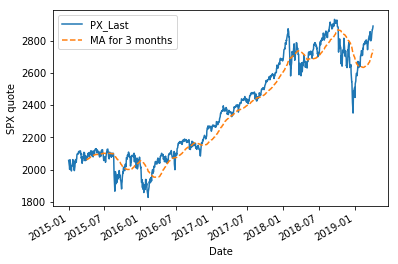

In [2]:
df.plot()
df['PX_Last'].rolling(window=63,center=False).mean().plot(style='--',label="MA for 3 months")
plt.ylabel('SPX quote')
plt.legend()
plt.show()

In [3]:
df.describe()

,PX_Last
count,1072.000000
mean,2361.583116
std,303.062073
min,1829.080000
25%,2091.020000
50%,2339.880000
75%,2658.585000
max,2930.750000


In [4]:
days=len(df['2016-01-04' :'2019-01-03'])
print("Number of trading days during the life of the option= {}".format(days))

Number of trading days during the life of the option= 756


## 2. Black-Scholes formula for the pricing of European Calls

$C(S,t)$ is given below, where $S$ is the underlying, $K$ is the strike price, $r$ is the risk-free rate, q is the dividend yield, T-t is the time to maturity and $\sigma$ is the (constant)  annualized volatility of the underlying.

\begin{equation}
    C(S, t)=  Se^{-q(T-t)} N(d_1) -  K  e^{-r(T-t)} N( d_2) 
\end{equation}

\begin{equation}
    d_1= \frac{\ln{\left(\frac{S}{K}\right)} + (T-t)\left(r -q + \frac{\sigma^2}{2} \right)}{\sigma \sqrt{T-t}} 
\end{equation}

\begin{equation}
    d_2= \frac{\ln{\left(\frac{S}{K}\right)} + (T-t)\left(r -q - \frac{\sigma^2}{2} \right)}{\sigma \sqrt{T-t}} 
\end{equation}

\begin{equation}
    N(x)=\frac{1}{\sqrt{2\pi}} \int_{-\infty}^{x} e^{-\frac{1}{2}z^2} dz
\end{equation}

**Black-Scholes and d1 function.**

In [5]:
def d1(S,K,T,r,q,v):
    
    """ 
    Parameters
    ----------
    S -> Spot price
    K -> Strike price
    T-t -> Time to maturity (assume t=0 for convenience)
    r -> Risk-free rate
    q -> Dividend yield
    v -> Volatility
           
    Returns
    --------
    Formula for d1
    
    """
    d=(log(S/K)+(r-q+v*v/2)*T)/(v*sqrt(T))
    
    return d

In [6]:
def BS(Option,S,K,T,r,q,v):
    
    """ 
    Parameters
    ----------
    Option -> Call="c", Put otherwise
    S -> Spot price
    K -> Strike price
    T-t -> Time to maturity (assume t=0)
    r -> Risk-free rate
    q -> Dividend yield
    v -> Volatility
           
    Returns
    --------
    Price for a call or put vanilla option
    
    """
    
    d_1=d1(S,K,T,r,q,v)
    d_2=d_1-v*sqrt(T)
    if Option=='c':
        C=S*exp(-q*T)*norm.cdf(d_1)-K*exp(-r*T)*norm.cdf(d_2)
        return C
    else:
        P=K*exp(-r*T)*norm.cdf(-d_2)-S*exp(-q*T)*norm.cdf(-d_1)
        return P

Global variables

In [7]:
S=df.loc['2016-01-04', ["PX_Last"]].iloc[0]
K=2500
T=days/252
r=0.0
q=0.0
v=0.2
T

3.0

In [8]:
Call=BS('c',S,K,T,r,q,v)
print('\033[1m' "Call price={}".format(round(Call,3)))

Call price=124.601


Call price over time

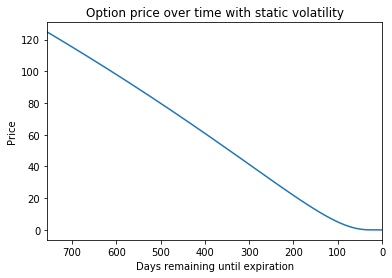

In [9]:
option=[]
ttm=np.arange(1,days+1,1)
for n in ttm:
    Call=BS('c',S,K,n/252,r,q,v)
    option.append(Call)
plt.plot(option)
plt.xlim(len(ttm), 0)
plt.xlabel('Days remaining until expiration')
plt.ylabel('Price')
plt.title("Option price over time with static volatility")
plt.show()

## 3. Option Greeks

### Delta

\begin{equation}
	\delta_{call}=  e^{-qT}N(d1) \\
    \delta_{put}=  -e^{-qT}N(-d1) 
\end{equation}

In [10]:
def delta(Option, S,K,T,r,q,v):
        
    """ 
    Parameters
    ----------
    Option -> Call="c", Put otherwise
    S -> Spot price
    K -> Strike price
    T-> Time to maturity
    r -> Risk-free rate
    q -> Dividend yield
    v -> Volatility
           
    Returns
    --------
    Delta for a call or put vanilla option
    
    """    
    d_1=d1(S,K,T,r,q,v)
    N_d1_call=norm.cdf(d_1)*exp(-q*T)
    N_d1_put=-norm.cdf(-d_1)*exp(-q*T)
    
    if Option=='c':
        return N_d1_call
    else:
        return N_d1_put

In [11]:
d=round(delta('c', S,K,T,r,q,v),3)
print('Delta= {}'.format(d))
print( '\033[1m Delta-hedging strategy if a market-maker sells call options:' 
      '\n Buy {} shares of the underlying stock now. Adjust the shares over time to maintain a \n delta-neutral portfolio.'.format(d))

Delta= 0.325
 Delta-hedging strategy if a market-maker sells call options:
 Buy 0.325 shares of the underlying stock now. Adjust the shares over time to maintain a 
 delta-neutral portfolio.


### Gamma

\begin{equation}
	\gamma=  \frac{N'(d1) e^{-qT}}{S_t \sigma \sqrt{T}}
\end{equation}

In [12]:
def gamma(S,K,T,r,q,v):
        
    """ 
    Parameters
    ----------
    Option -> Call="c", Put otherwise
    S -> Spot price
    K -> Strike price
    T -> Time to maturity
    r -> Risk-free rate
    q -> Dividend yield
    v -> Volatility
           
    Returns
    --------
    Gamma for a European option
    
    """    
    d_1=d1(S,K,T,r,q,v)
    g=norm.pdf(d_1)*exp(-q*T)/(S*v*sqrt(T))
    
    return g

In [13]:
g=round(gamma(S,K,T,r,q,v),5)
print( 'Gamma= {}'. format(g))

Gamma= 0.00052


### Vega

\begin{equation}
	\upsilon=  N'(d1) e^{-qT} S_t \sqrt{T}
\end{equation}

In [14]:
def vega(S,K,T,r,q,v):  
    
    """ 
    Parameters
    ----------
    S -> Spot price
    K -> Strike price
    T -> Time to maturity
    r -> Risk-free rate
    q -> Dividend yield
    v -> Volatility     
           
    Returns
    --------
    Vega for a European option
    
    """    
    d_1=d1(S,K,T,r,q,v)
    v=norm.pdf(d_1)*S*sqrt(T)*exp(-q*T)
    
    return v

In [15]:
vg=round(vega(S,K,T,r,q,v),3)
print('Vega= {}'.format(vg))
print( '\033[1m' 'A 1% increase in the volatility from 20% to 21% increases the value of the option by approximately {}'.format(vg*0.01))

Vega= 1255.255
A 1% increase in the volatility from 20% to 21% increases the value of the option by approximately 12.552550000000002


### Theta

\begin{equation}
	\theta_{call}= \frac{-S_t N'(d1) e^{-qT} \sigma}{2 \sqrt{T}} +qS_t N(d1) e^{-qT}-rKe^{-rT}N(d2)
\end{equation}

\begin{equation}
	\theta_{put}= -\frac{-S_t N'(d1) e^{-qT} \sigma}{2 \sqrt{T}} -qS_t N(-d1) e^{-qT}+rKe^{-rT}N(-d2)
\end{equation}

In [16]:
def theta(Option, S,K,T,r,q,v):
    
    """ 
    Parameters
    ----------
    S -> Spot price
    K -> Strike price
    T -> Time to maturity
    r -> Risk-free rate
    q -> Dividend yield
    v -> Volatility
             
    Returns
    --------
    Theta for a call or put vanilla option
    
    """    
    d_1=d1(S,K,T,r,q,v) 
    d_2 = d_1 - v * sqrt(T)
    
    if Option=='c':
        theta = -S * norm.pdf(d_1) * v *exp(-q*T)/ (2 * sqrt(T)) \
                 +q*S* norm.cdf(d_1)*exp(-q*T) \
                  - r * K * exp(-r*T) * norm.cdf(d_2)
        return theta
    
    else:
        theta = -S * norm.pdf(d_1) * v *exp(-q*T)/ (2 * sqrt(T)) \
                  -q*S* norm.cdf(-d_1)*exp(-q*T) \
                  +r * K * exp(-r*T) * norm.cdf(-d_2)
        return theta

In [17]:
th=round(theta('c', S,K,T,r,q,v),3)
print('Theta= {}'.format(th))
print( '\033[1m' 'Theta is equal to {} per trading day.'.format(th/252))

Theta= -41.842
Theta is equal to -0.16603968253968254 per trading day.


### Rho

\begin{equation}
	\rho_{call}= KTe^{-rT}N(d2)
\end{equation}

\begin{equation}
	\rho_{put}= -KTe^{-rT}N(-d2)
\end{equation}

In [18]:
def rho(Option, S,K,T,r,q,v):
    """ 
    Parameters
    ----------
    Option -> Call="c", Put otherwise
    S -> Spot price
    K -> Strike price
    T -> Time to maturity
    r -> Risk-free rate
    q -> Dividend yield
    v -> Volatility
           
    Returns
    --------
    Rho for a call or put vanilla option
    
    """    
    d_1=d1(S,K,T,r,q,v) 
    d_2 = d_1-v* sqrt(T)
    
    if Option=='c':
        rh=K*T*norm.cdf(d_2)*exp(-r*T)
        return rh
    
    else:
        rh=-K*T*exp(-r*T)*norm.cdf(-d_2)* exp(-r*T)
        return rh

In [19]:
rh=round(rho('c', S,K,T,r,q,v),3)
print('Rho= {}'.format(rh))
print( '\033[1m' 'A 1% increase in the interest rate increases the value of the option by approximately {}'.format(rh*0.01))

Rho= 1590.764
A 1% increase in the interest rate increases the value of the option by approximately 15.907639999999999


### Option price and greeks over time

In [20]:
def plot_greeks(Time, Option):    
    
    """  
    Parameters
    ----------
    Time -> Time to maturity
    Option -> Call="c", Put otherwise
    
    Returns
    --------
    Multiples graphs for the option price, delta, gamma, theta, vega and rho over time.
    """

    time=np.arange(0.001,Time+0.001,0.001)
    bs= []
    dt=[]
    gm=[]
    vg=[]
    th=[]
    rh=[]
    for n in time:
        Call = BS(Option,S,K,n,r,q,v)
        Delta=delta(Option,S,K,n,r,q,v)
        Gamma=gamma(S,K,n,r,q,v)
        Vega=vega(S,K,n,r,q,v)*0.01
        Theta=theta(Option,S,K,n,r,q,v)/252
        Rho=rho(Option,S,K,n,r,q,v)*0.01
        bs.append(Call),dt.append(Delta), gm.append(Gamma), vg.append(Vega), th.append(Theta), rh.append(Rho)        
          
    # Create a figure
    fig = plt.figure(figsize=(14,7))
    _ = plt.subplots_adjust(wspace = 0.4, hspace = 0.6 )
    fig.suptitle('Option Price and Greeks over time', fontweight="bold")

    # Create a plot of price over time
    ax = fig.add_subplot(2, 3, 1)
    _ = ax.plot(time , bs, color="blue")
    _ = ax.set_title("Option price", fontweight="bold")
    _ = ax.set_xlabel("Time to maturity (years)"); _ = ax.set_ylabel("Option price")
    
    # Create a plot of delta over time
    ax = fig.add_subplot(2, 3, 2)
    _ = ax.plot(time, dt, color="blue")
    _ = ax.set_title("Delta", fontweight="bold")
    _ = ax.set_xlabel("Time to maturity (years)"); _ = ax.set_ylabel("Delta")
    
     # Create a plot of gamma over time
    ax = fig.add_subplot(2, 3, 3)
    _ = ax.plot(time , gm, color="blue")
    _ = ax.set_title("Gamma",fontweight="bold")
    _ = ax.set_xlabel("Time to maturity (years)"); _ = ax.set_ylabel("Gamma")

    # Create a plot of vega over time
    ax = fig.add_subplot(2, 3, 4)
    _ = ax.plot(time, vg, color="blue")
    _ = ax.set_title("Vega", fontweight="bold")
    _ = ax.set_xlabel("Time to maturity (years)"); _ = ax.set_ylabel("Vega")
    
    # Create a plot of theta over time
    ax = fig.add_subplot(2, 3, 5)
    _ = ax.plot(time, th, color="blue")
    _ = ax.set_title("Theta", fontweight="bold")
    _ = ax.set_xlabel("Time to maturity (years)"); _ = ax.set_ylabel("Theta")
    
    # Create a plot of rho over time
    ax = fig.add_subplot(2, 3, 6)
    _ = ax.plot(time, rh, color="blue")
    _ = ax.set_title("Rho", fontweight="bold")
    _ = ax.set_xlabel("Time (years)"); _ = ax.set_ylabel("Rho")
       
    return

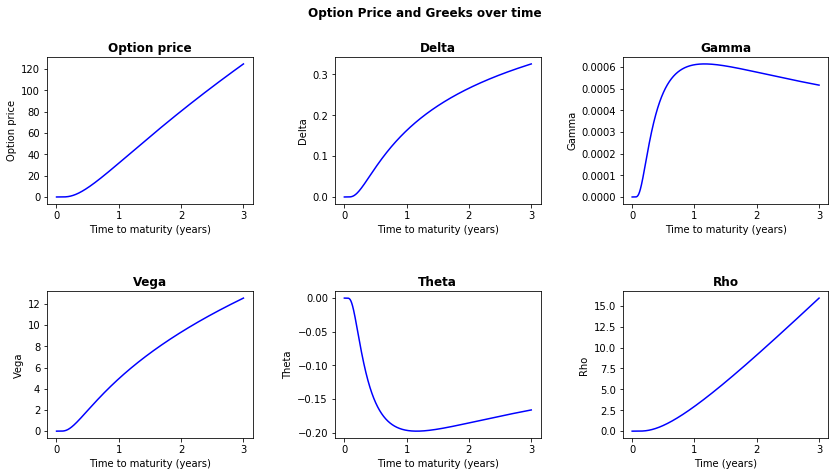

In [21]:
plot_greeks(3, 'c')

### Realized volatility

We can define realized volatility as:

\begin{equation}
	\sigma=\sqrt{ \frac{252}{n} \sum_{i=1}^{n-1} \left[ log \left({\frac{S_{i+1}}{S_i}}\right)\right] ^2}
\end{equation}

Reference: https://eu.spindices.com/indices/strategy/sp-500-3-month-realized-volatility-index

In [22]:
def rvol(df, df_index, ndays):
        
    """ 
    Parameters
    ----------
    df -> Original data frame
    ndays -> Number of observations to estimate the realized volatility
    df_index -> Date column
   
    Returns
    --------
    Realized volatility 
    
    """ 
    time=df.loc[df_index].values.tolist()
    rvol=[]
    for d in df_index[ndays:]:
        pct= df.loc[:d]['PX_Last'].tail(ndays).pct_change()
        pct=pct.dropna()
        pct=pct**2
        pct=pct.sum()
        vol=sqrt(pct*252/(ndays))
        rvol.append(vol)
    df_vol = pd.DataFrame(rvol, df_index[100:], columns=['Volatility'])
    
    return df_vol

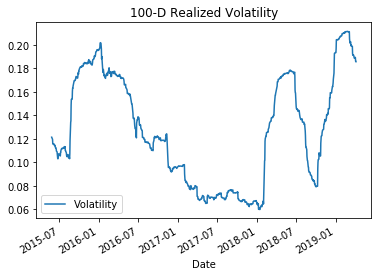

In [23]:
realized_vol=rvol(df, df_index, 100)
realized_vol.plot()
plt.title('100-D Realized Volatility')
plt.show()

In [24]:
rv=realized_vol['Volatility']
print('\033[1m' "Realized volatility as of '2016-01-04'= {}".format(rv['2016-01-04']))

Realized volatility as of '2016-01-04'= 0.19676558124588042


In [25]:
rv_1obs=rv['2016-01-04']

### Option price using realized volatility

In [26]:
Call_rvol=BS('c',S,K,T,r,q,rv_1obs)

In [27]:
diff=BS('c',S,K,T,r,q,v)-BS('c',S,K,T,r,q,rv_1obs)
print('\033[1m' 'Difference in the option price using static volatility and realized volatility={}'.format(diff))

Difference in the option price using static volatility and realized volatility=4.047948335779665


## 4. Daily PnL on a delta-hedged option

The hedging strategy consists of taking a stock position by an amount equal to the option’s delta.

**Suppose a market-maker sells one call option, and the market-maker buys delta shares to delta-hedge her position. Because the option delta changes as the stock price changes, the market-maker must continually review and modify their hedging decisions.**

The daily PnL on a delta-hedged option is defined as:

\begin{equation}
    PnL =\delta_{t-1}(S_t-S_{t-1})-(C_t-C_{t-1})-rX_{t-1} 
\end{equation}

$$PnL=\textit{Delta-hedging PnL+Option PnL+Interest on outstanding cash balance}$$  

Where $\delta_t$ denotes the option delta, $S_t$ the stock price, $C_t$ the option price at time $t$, and $X_{t-1}$ is the value of the portfolio at time $t-1$. This expression includes the overnight gain on shares, less the overnight gain on option, less interest owed (carrying cost of purchasing stocks).

We can derive the last expression if we denote the value of the portfolio at time $t$ as $X_{t}= \delta_{t}S_t-C_t$, the cost of purchasing additional shares as $S_i (\delta_{t}-\delta_{t-1}) $, and the interest owed as $rX_{t-1}$. Thus, the daily mark-to-market profit or loss is defined as:

\begin{equation}
\begin{aligned}
PnL &= X_{t}-X_{t-1}-S_{t}(\delta_{t}-\delta_{t-1})-rX_{t-1} \\
            &= (\delta_{t}S_t-C_t)-(\delta_{t-1}S_{t-1}-C_{t-1})-S_{t}(\delta_{t}-\delta_{t-1})-rX_{t-1}\\
            &= \delta_{t-1}(S_t-S_{t-1})-(C_t-C_{t-1})-rX_{t-1}\\
\end{aligned}
\end{equation}


If the market-maker had purchased a call and shorted delta shares, the profit calculation would be reversed. In the following exercise, we'll permit fractional share purchases and assume r=0.

<div class="alert alert-block alert-info">
    <b>Code explanation:</b> 
    <ul>
        <li>I created multiple lists to hold the values of the spot price, realized volatility and time to maturity. I used them to update the option price and risk factors.</li>
        <li>I created a copy of the original data frame and added columns to show the inputs needed to calculate the PnL.</li>
        <li>The new data frame gives a practical representation of the day-by-day activity assuming daily re-hedging to be delta neutral.</li>
</div>

In [28]:
def PnL_dh(Option, df, df_vol, num_cont, date1, date2, p):

    """ 
    Parameters
    ----------
    Option -> Call option="c"
    df_vol-> Volatility
    df -> Original data frame
    num_cont-> Number of contracts
    date1 -> Start date
    date2 -> End date
    p-> -1 short or +1 long position on the option
           
    Returns
    --------
    Daily PnL using delta hedging
    
    """    
    spot= df.loc[date1:date2]['PX_Last'].values.tolist()
    rv=df_vol.loc[date1:date2]['Volatility'].values.tolist()
    num_days=len(df[date1:date2])    
    ttm=list(range(1, num_days+1, 1))[::-1]
    
    dt=[] 
    bs=[]
    for a, b,c in zip(spot, ttm, rv):
        Call = BS(Option,a,K,b/252,r,q,c)
        Delta=delta(Option,a,K,b/252,r,q,c)
        bs.append(Call), dt.append(Delta)
    df=df.loc[date1:date2].copy()
    df['Option_Price'] = bs
    df['Delta'] = dt
    df['Delta_Hedging_PnL']=df['PX_Last'].diff()*df['Delta'].shift(1)
    df['Option_PnL']=df['Option_Price'].diff()
    df['PnL']= p*num_cont*(df['Option_PnL']-df['Delta_Hedging_PnL'])
    df['Total_PnL']=df['PnL'].cumsum() 
    
    return df

In [29]:
p=-1
num_cont=1
dh=PnL_dh('c', df, realized_vol, num_cont, '2016-01-04', '2019-01-03', p)
PnL=dh['PnL'].sum()
print('\033[1m' 'Total PnL= {}'.format(PnL))

Total PnL= 32.9007174966863


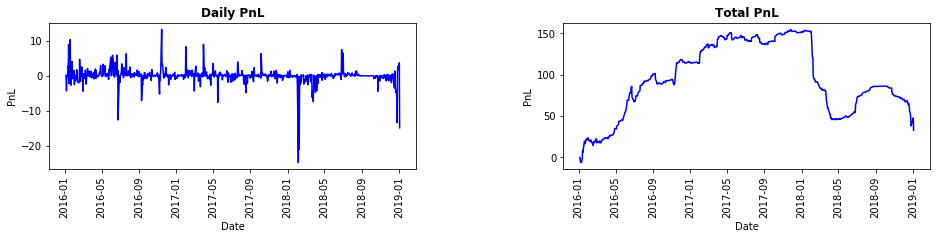

In [30]:
fig = plt.figure(figsize=(25,7))
_ = plt.subplots_adjust(wspace = 0.4, hspace = 0.6 )

ax = fig.add_subplot(2, 3, 1)
_ = ax.plot(dh['PnL'], color="blue")
_ = ax.set_title("Daily PnL", fontweight="bold")
_ = ax.set_xlabel("Date"); _ = ax.set_ylabel("PnL")
_=plt.xticks(rotation=90)
   

ax = fig.add_subplot(2, 3, 2)
_ = ax.plot(dh['Total_PnL'], color="blue")
_ = ax.set_title("Total PnL", fontweight="bold")
_ = ax.set_xlabel("Date"); _ = ax.set_ylabel("PnL")
_=plt.xticks(rotation=90)

In [31]:
dh.tail()
#NAN values were left intentionally

,PX_Last,Option_Price,Delta,Delta_Hedging_PnL,Option_PnL,PnL,Total_PnL
Date,,,,,,,
2018-12-27,2488.83,21.829353,0.439927,7.104483,5.760827,1.343656,39.525342
2018-12-28,2485.74,17.708795,0.411694,-1.359374,-4.120558,2.761184,42.286526
2018-12-31,2506.85,24.675899,0.555758,8.690871,6.967104,1.723767,44.010292
2019-01-02,2510.03,22.695452,0.595228,1.767310,-1.980447,3.747757,47.758049
2019-01-03,2447.89,0.565344,0.045420,-36.987440,-22.130109,-14.857332,32.900717


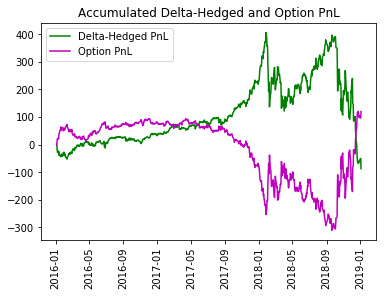

In [32]:
dh_pnl=p*(-dh['Delta_Hedging_PnL'].cumsum())
option_pnl=p*dh['Option_PnL'].cumsum()
plt.plot(dh_pnl, c='g', label="Delta-Hedged PnL")
plt.plot(option_pnl,c='m', label="Option PnL")
plt.title('Accumulated Delta-Hedged and Option PnL')
plt.xticks(rotation=90)
plt.legend(loc=2)
plt.show()

### PnL attribution via the BSM model

Delta, gamma, theta and vega all play a role in determining the profit on a delta-hedged position. One can perform a Taylor expansion of the option value change over a short time interval equal to h (i.e. one day):

\begin{equation}
     C_{t+h}-C_{t}= \delta_{t} \epsilon +
     \frac{1}{2}\Gamma_{t} (\epsilon)^2+\theta_{t} h + \upsilon_{t} \Delta \sigma_t \\
\end{equation}
$$\text{ Where }  \ \epsilon= S_{t+h}-S_{t} \ \text{ and }\ h=1/252$$
We therefore obtain

\begin{equation}
\begin{aligned}
	PnL &= \delta_{t}\epsilon-(C_{t+h}-C_{t})-rX_{t}\\ 
        &= \delta_{t}\epsilon-(\delta_{t} \epsilon +\frac{1}{2}\Gamma_{t} (\epsilon)^2+\theta_{t} h + \upsilon_{t} \Delta \sigma_t)-rX_{t}\\
	   &= -\Bigg (\frac{1}{2}\Gamma_{t} (\epsilon)^2+\theta_{t} h + \upsilon_{t} \Delta \sigma_t \Bigg ) -r(\delta_t S_{t} -C_{t})
\end{aligned}
\end{equation}

Second order effects such as Vanna and Volga are not considered for this exercise. 

In [33]:
def PnL_att(Option, df, df_vol, num_cont, date1, date2, h, p):

    """ 
    Parameters
    ----------
    Option -> Call="c", otherwise, it is a Put
    df -> Original data frame
    df_volt -> Realized volatility
    num_cont-> Number of contracts
    date1 -> Start date
    date2 -> End date
    h-> Delta hedging frequency (i.e. h=1/252) 
    p-> -1 short or +1 long position on the option
           
    Returns
    --------
    Daily PnL attribution
    
    """    
    spot= df.loc[date1:date2]['PX_Last'].values.tolist()
    rv=df_vol.loc[date1:date2]['Volatility'].values.tolist()
    num_days=len(df[date1:date2])
    ttm=list(range(1, num_days+1, 1))[::-1]
    
    gm=[] 
    th=[]
    vg=[]
    for a, b, c in zip(spot, ttm, rv):
        Gamma = gamma(a,K,b/252,r,q,c)
        Theta=theta(Option,a,K,b/252,r,q,c)
        Vega=vega(a,K,b/252,r,q,c)
        gm.append(Gamma), th.append(Theta), vg.append(Vega)
    df=df.loc[date1:date2].copy()
    df['Stock_chg']=df['PX_Last'].diff()
    df['rvol'] = rv
    df['rvol_chg'] = df['rvol'].diff()
    df['Gamma'] = gm
    df['Theta'] = th
    df['Vega'] = vg
    df['Gamma_PnL'] = 0.5* (df['Stock_chg']**2)*(df['Gamma'].shift(1))
    df['Theta_PnL'] = h*df['Theta'].shift(1)
    df['Vega_PnL'] = df['rvol_chg']*(df['Vega'].shift(1))
    df['PnL']=p*num_cont*(df['Gamma_PnL']+ df['Theta_PnL']+df['Vega_PnL'])
    df['Total_PnL']=df['PnL'].cumsum() 
        
    return df

In [34]:
h=1/252
dh_att=PnL_att('c', df, realized_vol, 1, '2016-01-04', '2019-01-03', h, p)
PnL_att=dh_att['PnL'].sum()
print('\033[1m' 'Total PnL via the BMS model= {}'.format(PnL_att))

Total PnL via the BMS model= 61.61338478241208


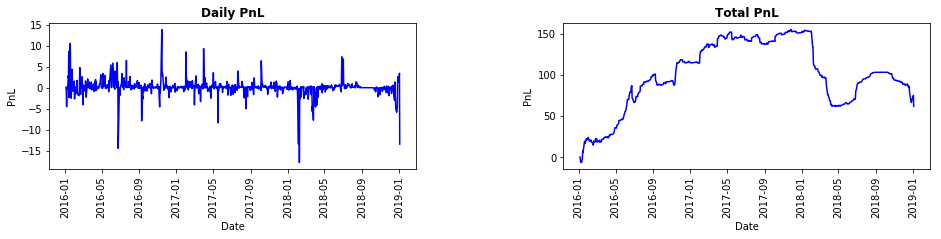

In [35]:
fig = plt.figure(figsize=(25,7))
_ = plt.subplots_adjust(wspace = 0.4, hspace = 0.6 )

ax = fig.add_subplot(2, 3, 1)
_ = ax.plot(dh_att['PnL'], color="blue")
_ = ax.set_title("Daily PnL", fontweight="bold")
_ = ax.set_xlabel("Date"); _ = ax.set_ylabel("PnL")
_=plt.xticks(rotation=90)
   

ax = fig.add_subplot(2, 3, 2)
_ = ax.plot(dh_att['Total_PnL'], color="blue")
_ = ax.set_title("Total PnL", fontweight="bold")
_ = ax.set_xlabel("Date"); _ = ax.set_ylabel("PnL")
_=plt.xticks(rotation=90)

In [36]:
dh_att.tail()
#NAN values were left intentionally

,PX_Last,Stock_chg,rvol,rvol_chg,Gamma,Theta,Vega,Gamma_PnL,Theta_PnL,Vega_PnL,PnL,Total_PnL
Date,,,,,,,,,,,,
2018-12-27,2488.83,21.13,0.192969,0.000397,0.005830,-672.382854,138.270239,1.110722,-2.229332,0.055207,1.063403,67.501249
2018-12-28,2485.74,-3.09,0.192927,-0.000042,0.006440,-740.597241,121.864928,0.027834,-2.668186,-0.005810,2.646162,70.147411
2018-12-31,2506.85,21.11,0.193397,0.000470,0.007468,-877.663322,108.051085,1.435032,-2.938878,0.057277,1.446569,71.593981
2019-01-02,2510.03,3.18,0.193394,-0.000003,0.008961,-1055.779932,86.654315,0.037760,-3.482791,-0.000330,3.445362,75.039343
2019-01-03,2447.89,-62.14,0.197023,0.003629,0.003143,-365.572942,14.726045,17.301062,-4.189603,0.314499,-13.425958,61.613385


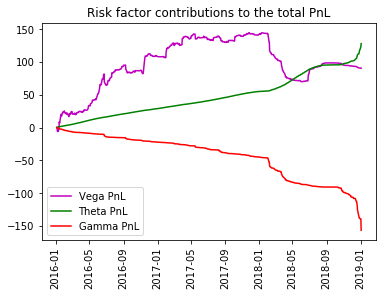

In [37]:
gm_pnl=p*dh_att['Gamma_PnL'].cumsum()
vg_pnl=p*dh_att['Vega_PnL'].cumsum()
th_pnl=p*dh_att['Theta_PnL'].cumsum()
plt.plot(vg_pnl,c='m', label="Vega PnL")
plt.plot(th_pnl,c='g', label="Theta PnL")
plt.plot(gm_pnl, c='r', label="Gamma PnL")
plt.title('Risk factor contributions to the total PnL')
plt.xticks(rotation=90)
plt.legend(loc=3)
plt.show()

## 5. Results

- We applied the Black-Scholes formula to price a 3-year European call on the SPX with a strike price of 2500, an implied volatility of 20% per annum, and we assumed a risk-free rate and dividend yield equal to zero. 
- For this exercise, I worked with functions rather than objects because they are easier to manipulate.

In [38]:
print('\033[1m' "\n Price of a European call using a static volatility={} \n Price using the realized volatility={}".format(round(Call,3),round(Call_rvol,3)))


 Price of a European call using a static volatility=124.601 
 Price using the realized volatility=120.553


- Additionally, we quantified different aspects of the risk in an option position: delta, gamma, vega, theta and rho. And we plotted the Greek letters against time. The figures show a typical pattern for an out-the-money call option.
    - The delta, gamma and vega of the out-of-the-money call option will get closer to zero as expiration approaches.
    - Theta increases as expiration approaches.

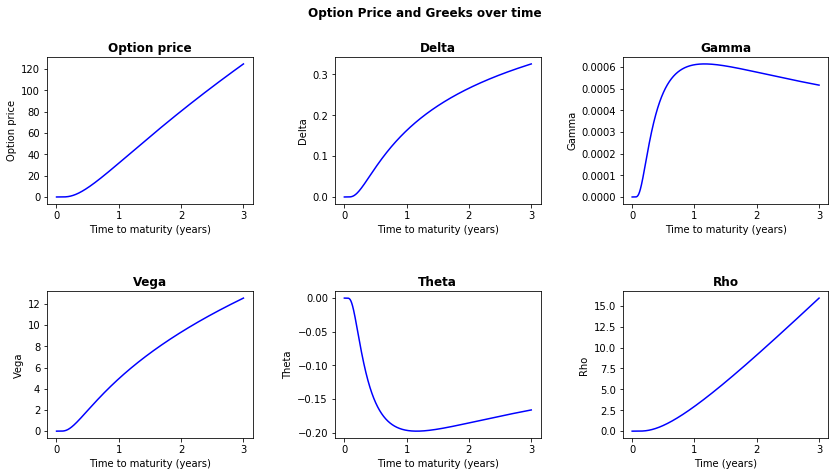

In [39]:
plot_greeks(3, 'c')

- The analysis also includes the calculation of the 100-D realized volatility observed during the life of the option, which was used to update the option price and Greek letters in the delta-hedging exercise.

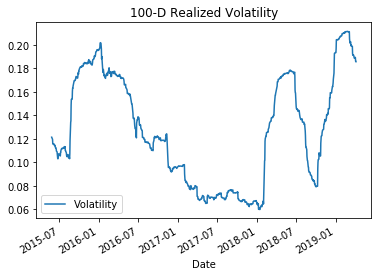

In [40]:
realized_vol.plot()
plt.title('100-D Realized Volatility')
plt.show()

Lastly, I will explain how the delta-hedging procedure works by going through the code and tables in detail.
-  Day 0: The market-maker sells the option to a client at a price of 120.553, corresponding to an implied volatility of 19.67%, receiving her first cash flow. The market-maker also buys 0.32 shares.
- Day 1: Marking-to-market and rebalancing the portfolio. The market-maker makes a profit of $0.1394 and buys (sells) additional shares if delta increased (decreased).
- Day 2: Marking-to-market and rebalancing the portfolio, and so on.
- **The total PnL is positive due to the increase in the stock price during the life of the option: delta increases and the stock is making money faster than short call loses money.**

The calculations for the daily PnL on a delta-hedged option used actual option price changes over 1 day. However, the PnL attribution via the BSM model approximates the change in the option price. Therefore, the replication is not perfect.  
**PnL Attribution**
-  Gamma PnL: Since Gamma is positive, the market-maker loses money in proportion to the
square of the stock price change. Additionally, in the presence of large moves on the SPX, the market-maker loses money faster. 
- Vega PnL: A decrease in volatility benefits the option writer.
- Theta PnL: Since theta is negative, the option writer benefits from theta.


 Total PnL=32.901 
 Total PnL via the BMS model=61.613


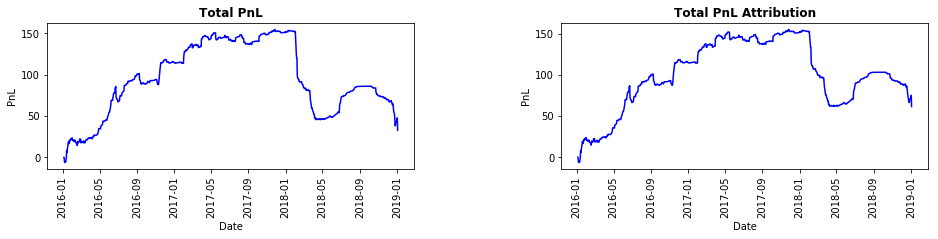

In [41]:
print('\033[1m' "\n Total PnL={} \n Total PnL via the BMS model={}".format(round(PnL,3),round(PnL_att,3)))

fig = plt.figure(figsize=(25,7))
_ = plt.subplots_adjust(wspace = 0.4, hspace = 0.6 )

ax = fig.add_subplot(2, 3, 1)
_ = ax.plot(dh['Total_PnL'], color="blue")
_ = ax.set_title("Total PnL", fontweight="bold")
_ = ax.set_xlabel("Date"); _ = ax.set_ylabel("PnL")
_=plt.xticks(rotation=90)
   

ax = fig.add_subplot(2, 3, 2)
_ = ax.plot(dh_att['Total_PnL'], color="blue")
_ = ax.set_title("Total PnL Attribution", fontweight="bold")
_ = ax.set_xlabel("Date"); _ = ax.set_ylabel("PnL")
_=plt.xticks(rotation=90)